## Checking the NVIDIA 

In [1]:
!nvidia-smi
!nvcc --version

Mon Mar 10 10:19:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   49C    P5              9W /  100W |     461MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Connecting ArangoDB with docker

In [2]:
from arango import ArangoClient
from langchain_community.graphs import ArangoGraph
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
import networkx as nx
import nx_arangodb as nxadb

ARANGO_URL = "http://localhost:8529"
DB_NAME = "news_db"
USERNAME = "root"
PASSWORD = "123"

client = ArangoClient(hosts=ARANGO_URL)
db = client.db("news", username=USERNAME, password=PASSWORD)
scheduling_db = client.db("scheduling", username=USERNAME, password=PASSWORD)

arango_graph = ArangoGraph(db)

G_adb = nxadb.MultiGraph(name="news_graph", db=db)


def delete_key_recursively(d, key_to_delete):
    if isinstance(d, dict):
        if key_to_delete in d:
            del d[key_to_delete]
        for key in list(d.keys()):
            delete_key_recursively(d[key], key_to_delete)
    elif isinstance(d, list):
        for item in d:
            delete_key_recursively(item, key_to_delete)
    return d

graph_schema = delete_key_recursively(arango_graph.schema, "example_document")
graph_schema = delete_key_recursively(graph_schema, "example_edge")


[10:19:29 +0530] [INFO]: NetworkX-cuGraph is available.
[10:19:29 +0530] [INFO]: Graph 'news_graph' exists.
[10:19:29 +0530] [INFO]: Default node type set to 'categories'


### AI Models Connection

In [3]:
from langchain_ollama import ChatOllama
from langchain_openai import ChatOpenAI
import os
from dotenv import load_dotenv
load_dotenv()

ollama_llm = ChatOllama(model="llama3.1:latest", temperature=5)
chatgpt_llm = ChatOpenAI(
    model= "gpt-4o-mini",
    # model="gpt-4o",
    api_key=os.getenv("OPENAI_KEY")
)

## Dataset Preparation.

#### Dataset Type:
I have taken the dataset from [Kaggle](https://www.kaggle.com/datasets/everydaycodings/global-news-dataset?select=data.csv), Which is a gloabl news dataset. I sorted out many rows for the demostration purpose, only taking 5000 rows.

#### Entities:
I have used 4 nodes namely Categories, Characters, Countries and Summaries and one Edge collection.
All 4 nodes are linked to summaries.



In [4]:
import pandas as pd

df = pd.read_csv("original_data.csv")  
df = df.dropna()
df = df[~df["author"].str.contains(r"https?://|www\.", na=False, regex=True)]  
df = df.drop(columns=["category", "content", "article_id", "source_id"])
df["published_at"] = pd.to_datetime(df["published_at"], format="mixed").dt.date
df.to_csv("cleaned_data.csv", index=False)

In [5]:
import pandas as pd

df = pd.read_csv("cleaned_data.csv")  

rows, cols = df.shape  
print(f"Total Rows: {rows}, Total Columns: {cols}")  
print("Column Names:", list(df.columns)) 

Total Rows: 15793, Total Columns: 8
Column Names: ['source_name', 'author', 'title', 'description', 'url', 'url_to_image', 'published_at', 'full_content']


In [6]:
from langchain_ollama import ChatOllama 

llm = ChatOllama(
    model="qwen2.5:7b",
    temperature=0,
)

##### The code below is extracting the entitites from original news and append to CSV file inside the updated_dataset directory. I am chunking and doinf 1000 records, because it took me to finish 15000 record in approximately 8 houres using ollama.

##### I recommending not run this(if u wish, you can)

In [ ]:
from concurrent.futures import ThreadPoolExecutor
import time, re, json

source_data_set = "./splitted_dataset/part_14.csv"
udpated_data_set = "./updated_dateset/part_14.csv"
df = pd.read_csv(source_data_set)
print("Original Rows:", len(df))


def process_row(index):
    full_content = df.loc[index, "full_content"]

    messages = [
        ("system", "You are a helpful assistant that summarizes news articles and extracts key details."),
        ("human", f"""Summarize the following news article. Additionally, extract the category of the news and list the main people (characters) involved and extract only people name not their designations and some others.

        ### News Article:
        {full_content}

        ### Instructions:
        Return a **valid JSON** response with this exact structure:
        ```json
        {{
            "summarized_content": "Brief summary of the article about 100 or 150 words long",
            "category": ["Category1", "Category2"] or [],
            "characters": ["Person1", "Person2", "Person3"] or [],
            "country": ["Identified country"] or []
        }}
        ```
        - If **no category, characters, or country** are found, return an **empty array `[]`**, not `"None mentioned in the article"`.
        - The response must be in **valid JSON format**.
        """),
    ]

    attempts = 3
    for _ in range(attempts):
        try:
            ai_msg = llm.invoke(messages)
            response_data = ai_msg.content.strip()

            match = re.search(r"```(?:json)?\n(.*?)\n```", response_data, re.DOTALL)
            json_str = match.group(1) if match else response_data.strip()
            response_data = json.loads(json_str)

            return (
                index,
                response_data.get("summarized_content", "N/A"),
                ", ".join(response_data.get("category", [])),
                ", ".join(response_data.get("characters", [])),
                ", ".join(response_data.get("country", [])),
            )

        except json.JSONDecodeError:
            time.sleep(1)

    return index, "N/A", "", "", ""


num_threads = 10

start_time = time.time()

with ThreadPoolExecutor(max_workers=num_threads) as executor:
    results = list(executor.map(process_row, range(len(df))))

for index, summary, category, characters, country in results:
    df.loc[index, "summarized_content"] = summary
    df.loc[index, "category"] = str(category) if category else ""
    df.loc[index, "characters"] = str(characters) if characters else ""
    df.loc[index, "country"] = str(country) if country else ""

df.to_csv(udpated_data_set, index=False)

end_time = time.time()
# print(f"Time taken: {end_time - start_time:.2f} seconds")


#### Concatenting the dataset 

For demonstration, I took only 5000 rows

In [7]:
chunk_size = 1000
num_splits = 5

df = pd.concat([pd.read_csv(f"./updated_dateset/part_{i+1}.csv") for i in range(num_splits)], ignore_index=True)


rows, cols = df.shape  
print(f"Total Rows: {rows}, Total Columns: {cols}")  
print("Column Names:", list(df.columns))  

Total Rows: 5000, Total Columns: 12
Column Names: ['source_name', 'author', 'title', 'description', 'url', 'url_to_image', 'published_at', 'full_content', 'summarized_content', 'category', 'characters', 'country']


##### Creating the edges and relations.

Below code create the edges and relations to the node each another.

In [10]:


# Delete existing graphs
import hashlib
from arango import ArangoClient
from langchain_community.graphs import ArangoGraph
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
import networkx as nx
import nx_arangodb as nxadb

ARANGO_URL = "http://localhost:8529"
DB_NAME = "news_db"
USERNAME = "root"
PASSWORD = "123"

client = ArangoClient(hosts=ARANGO_URL)
db = client.db("news", username=USERNAME, password=PASSWORD)
scheduling_db = client.db("scheduling", username=USERNAME, password=PASSWORD)

graphs = db.graphs()
for graph in graphs:
    db.delete_graph(graph["name"], drop_collections=True)

# Delete existing collections
collections = db.collections()
for collection in collections:
    if not collection['name'].startswith('_'):
        db.delete_collection(collection['name'])

# Create required collections
collections = ["categories", "characters", "countries", "summaries", "edges"]
for collection in collections:
    if not db.has_collection(collection):
        db.create_collection(collection)

def generate_key(value):
    return hashlib.md5(str(value).encode()).hexdigest()

categories, characters, countries = set(), set(), set()
source_keys, author_keys, category_keys, character_keys, country_keys = {}, {}, {}, {}, {}
edges, summaries = [], {}

for _, row in df.iterrows():
    source, author = row['source_name'], row['author']
    char_list = [char.strip() for char in str(row['characters']).split(",") if char.strip()]
    category_list = [cat.strip() for cat in str(row['category']).split(",") if cat.strip()]
    country_list = [country.strip() for country in str(row['country']).split(",") if country.strip()]
    
    summary_text, title = row['summarized_content'], row['title']
    if not summary_text:
        continue
    summary_id = generate_key((summary_text))
    # summary_embedding = generate_embedding(summary_text)

    # Store summary
    summaries[summary_id] = {
        "_key": summary_id,
        "summary_content": summary_text,
        "published_at": row["published_at"],
        "url": row["url"],
        "url_to_image": row["url_to_image"],
        # "title": title,
        # "source": str(source),
        # "author":  str(author)
        # "embeddings" : summary_embedding
    }

    for country in country_list:
        if country not in country_keys:
            country_keys[country] = generate_key(country)
            countries.add(country)

    for char in char_list:
        if char not in character_keys:
            character_keys[char] = generate_key(char)
            characters.add(char)

    for cat in category_list:
        if cat not in category_keys:
            category_keys[cat] = generate_key(cat)
            categories.add(cat)


    for cat in category_list:
        edges.append({"_from": f"categories/{category_keys[cat]}", "_to": f"summaries/{summary_id}"})

    for char in char_list:
        edges.append({"_from": f"characters/{character_keys[char]}", "_to": f"summaries/{summary_id}"})
        for cat in category_list:
            edges.append({"_from": f"categories/{category_keys[cat]}", "_to": f"characters/{character_keys[char]}"})

    for country in country_list:
        edges.append({"_from": f"countries/{country_keys[country]}", "_to": f"summaries/{summary_id}"})

        for cat in category_list:
            edges.append({"_from": f"categories/{category_keys[cat]}", "_to": f"countries/{country_keys[country]}"})

        for char in char_list:
            edges.append({"_from": f"characters/{character_keys[char]}", "_to": f"countries/{country_keys[country]}"})

# Bulk Insert
db.collection("categories").import_bulk([{"_key": category_keys[c], "name": c} for c in categories])
db.collection("characters").import_bulk([{"_key": character_keys[ch], "name": ch} for ch in characters])
db.collection("countries").import_bulk([{"_key": country_keys[co], "name": co} for co in countries])
db.collection("summaries").import_bulk(list(summaries.values()))

if db.has_collection("edges"):
    db.delete_collection("edges")
db.create_collection("edges", edge=True)
db.collection("edges").import_bulk(edges)
print(len(edges))

# Create Graph
if db.has_graph("news_graph"):
    db.delete_graph("news_graph", drop_collections=True)

graph = db.create_graph("news_graph")
for collection in ["categories", "characters", "countries", "summaries"]:
    if not graph.has_vertex_collection(collection):
        graph.create_vertex_collection(collection)

if not graph.has_edge_definition("edges"):
    graph.create_edge_definition(
        edge_collection="edges",
        from_vertex_collections=["categories", "characters", "countries"],
        to_vertex_collections=["summaries"],
    )

G_adb = nxadb.MultiGraph(name="news_graph", db=db)


def delete_key_recursively(d, key_to_delete):
    if isinstance(d, dict):
        if key_to_delete in d:
            del d[key_to_delete]
        for key in list(d.keys()):
            delete_key_recursively(d[key], key_to_delete)
    elif isinstance(d, list):
        for item in d:
            delete_key_recursively(item, key_to_delete)
    return d

graph_schema = delete_key_recursively(arango_graph.schema, "example_document")
graph_schema = delete_key_recursively(graph_schema, "example_edge")


print("✅ Graph 'news_graph' created successfully!")
print("🎉 Now you can see the fully connected graph in ArangoDB UI: http://localhost:8529")


[10:38:49 +0530] [INFO]: Graph 'news_graph' exists.
[10:38:49 +0530] [INFO]: Default node type set to 'categories'


88058
✅ Graph 'news_graph' created successfully!
🎉 Now you can see the fully connected graph in ArangoDB UI: http://localhost:8529


## Checking the Testing Query with ArangoQAChain

In [18]:
import json
from langchain.prompts import PromptTemplate

base_prompt = PromptTemplate(
    template="Do not use OUTBOUND"
)

chain = ArangoGraphQAChain.from_llm(
    	llm=chatgpt_llm,
    	graph=arango_graph,
    	verbose=True,
        allow_dangerous_requests=True,
        base_prompt=base_prompt
    )

chain.top_k = 5
chain.return_aql_query = True
chain.return_aql_result = True
chain.max_aql_generation_attempts = 5
chain.aql_examples = """
## **important** Dont ever try to return the embedding fields and _id ever.

# Ihow many nodes and edges are there in graph??
WITH authors, categories, characters, countries, sources, summaries, edges
RETURN { 
  nodeCount: COUNT(FOR vertex IN summaries RETURN vertex), 
  edgeCount: COUNT(FOR edge IN edges RETURN edge) 
}

"""
res = chain.invoke("how many edges and nodes are there in graph?")
# res = chain.get_input_schema
print(res)



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH categories, characters, countries, summaries, edges
RETURN { 
  nodeCount: COUNT(FOR vertex IN summaries RETURN vertex), 
  edgeCount: COUNT(FOR edge IN edges RETURN edge) 
}

AQL Result:
[{'nodeCount': 4960, 'edgeCount': 88058}]

> Finished chain.
{'query': 'how many edges and nodes are there in graph?', 'result': 'The graph contains a total of 4,960 nodes and 88,058 edges.', 'aql_query': '\nWITH categories, characters, countries, summaries, edges\nRETURN { \n  nodeCount: COUNT(FOR vertex IN summaries RETURN vertex), \n  edgeCount: COUNT(FOR edge IN edges RETURN edge) \n}\n', 'aql_result': [{'nodeCount': 4960, 'edgeCount': 88058}]}


### Tools used

I have used three tools

1. Normal text to AQL Query
2. Executing the NetworkX algorithm.
Thanks for the Jupyter Notebook Template for this. It is working good with my use case.
3. Creating the visualization graph. This will create the graph and store it in current directory.

In [19]:
import re
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
@tool
def text_to_aql_to_text(query: str):
    """This tool is available to invoke the
    ArangoGraphQAChain object, which enables you to
    translate a Natural Language Query into AQL, execute
    the query, and translate the result back into Natural Language.
    """


    chain = ArangoGraphQAChain.from_llm(
    	llm=chatgpt_llm,
    	graph=arango_graph,
    	verbose=True,
        allow_dangerous_requests=True,
        base_prompt=base_prompt
    )

    chain.top_k = 5
    chain.return_aql_query = True
    chain.return_aql_result = True
    chain.max_aql_generation_attempts = 5
    chain.aql_examples = """
    ## **important** Dont ever try to return the embedding fields and _id ever.

    # Ihow many nodes and edges are there in graph??
    WITH authors, categories, characters, countries, sources, summaries, edges
    RETURN { 
    nodeCount: COUNT(FOR vertex IN summaries RETURN vertex), 
    edgeCount: COUNT(FOR edge IN edges RETURN edge) 
    }

    """
    result = chain.invoke(query)

    return str(result["result"])
@tool
def text_to_nx_algorithm_to_text(query):
    """This tool is available to invoke a NetworkX Algorithm on
    the ArangoDB Graph. You are responsible for accepting the
    Natural Language Query, establishing which algorithm needs to
    be executed, executing the algorithm, and translating the results back
    to Natural Language, with respect to the original query.

    If the query (e.g traversals, shortest path, etc.) can be solved using the Arango Query Language, then do not use
    this tool.
    """


    ######################
    print("1) Generating NetworkX code")

    text_to_nx = chatgpt_llm.invoke(f"""
    I have a NetworkX Graph called `G_adb`. It has the following schema: {graph_schema}

    I have the following graph analysis query: {query}.

    Generate the Python Code required to answer the query using the `G_adb` object.

    Be very precise on the NetworkX algorithm you select to answer this query. Think step by step.

    Only assume that networkx is installed, and other base python dependencies.

    Always set the last variable as `FINAL_RESULT`, which represents the answer to the original query.

    Only provide python code that I can directly execute via `exec()`. Do not provide any instructions.

    Make sure that `FINAL_RESULT` stores a short & consice answer. Avoid setting this variable to a long sequence.
    If asked for visualization image, Always store the image as graph.png in current dir
    Your code:
    """).content

    text_to_nx_cleaned = re.sub(r"^```python\n|```$", "", text_to_nx, flags=re.MULTILINE).strip()

    print('-'*10)
    print(text_to_nx_cleaned)
    print('-'*10)

    ######################

    print("\n2) Executing NetworkX code")
    global_vars = {"G_adb": G_adb, "nx": nx}
    local_vars = {}

    try:
        exec(text_to_nx_cleaned, global_vars, local_vars)
        text_to_nx_final = text_to_nx
    except Exception as e:
        print(f"EXEC ERROR: {e}")
        return f"EXEC ERROR: {e}"


    print('-'*10)
    FINAL_RESULT = local_vars["FINAL_RESULT"]
    print(f"FINAL_RESULT: {FINAL_RESULT}")
    print('-'*10)

    print("3) Formulating final answer")

    nx_to_text = chatgpt_llm.invoke(f"""
        I have a NetworkX Graph called `G_adb`. It has the following schema: {graph_schema}

        I have the following graph analysis query: {query}.

        I have executed the following python code to help me answer my query:

        ---
        {text_to_nx_final}
        ---

        The `FINAL_RESULT` variable is set to the following: {FINAL_RESULT}.

        Based on my original Query and FINAL_RESULT, generate a short and concise response to
        answer my query.

        Your response:
    """).content

    return nx_to_text

@tool
def text_to_graph_visualization(query):
    """This tool is available to invoke a NetworkX Algorithm on
    the ArangoDB Graph. You are responsible for accepting the
    Natural Language Query, establishing which algorithm needs to
    be executed, executing the algorithm, and translating the results back
    to Natural Language, with respect to the original query.

    If the query (e.g traversals, shortest path, etc.) can be solved using the Arango Query Language, then do not use
    this tool.
    """


    ######################
    print("1) Generating NetworkX code")

    text_to_nx = chatgpt_llm.invoke(f"""
    I have a NetworkX Graph called `G_adb`. It has the following schema: {graph_schema}

    I have the following graph analysis query: {query}.

    Generate the Python Code required to answer the query using the `G_adb` object.

    Be very precise on the NetworkX algorithm you select to answer this query and matplotlib for graph visualization. Think step by step.

    Only assume that networkx is installed, and other base python dependencies.

    Always set the last variable as `IMAGE`, which represents the answer to the original query.

    Only provide python code that I can directly execute via `exec()`. Do not provide any instructions.

    Make sure that `IMAGE` stores a generated image, i will convert that into base64 later. Avoid setting this variable to a long sequence.

    Always store the image as graph.png in current dir
    Your code:
    """).content

    text_to_nx_cleaned = re.sub(r"^```python\n|```$", "", text_to_nx, flags=re.MULTILINE).strip()

    print('-'*10)
    print(text_to_nx_cleaned)
    print('-'*10)

    ######################

    print("\n2) Executing NetworkX code")
    global_vars = {"G_adb": G_adb, "nx": nx}
    local_vars = {}

    try:
        exec(text_to_nx_cleaned, global_vars, local_vars)
        text_to_nx_final = text_to_nx
    except Exception as e:
        print(f"EXEC ERROR: {e}")
        return f"EXEC ERROR: {e}"


    IMAGE = local_vars["IMAGE"]
    

In [22]:
tools = [text_to_aql_to_text, text_to_nx_algorithm_to_text, text_to_graph_visualization]

def query_graph(query):
    app = create_react_agent(chatgpt_llm, tools=tools)

    final_state = app.invoke({"messages": [{"role": "user", "content": query}]})
    return final_state["messages"][-1].content

res = query_graph("which news is more influential country news in my graph?")
print(res)



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH countries, summaries, edges
FOR news IN summaries
SORT news.published_at DESC
RETURN news

AQL Result:
[{'_key': 'b698932170633b409083e49d591fee0d', '_id': 'summaries/b698932170633b409083e49d591fee0d', '_rev': '_jV3yn_y-Au', 'summary_content': 'The article discusses codependency, describing it as a tendency to excessively care for or control others. It highlights how people with this issue often struggle with emotional regulation and decision-making, leading to interpersonal conflicts and anxiety. The piece also explores the origins of codependency in childhood and its connection to virtues like kindness and empathy.', 'published_at': '2023-11-08', 'url': 'https://time.com/6331335/is-family-codependent/', 'url_to_image': 'https://api.time.com/wp-content/uploads/2023/11/FamilyCodependent.jpg?quality=85'}, {'_key': '95f61a0c72334e1617d7810cb075f33e', '_id': 'summaries/95f61a0c72334e1617d7810cb075f33e', '_rev': '_jV3yn_m-_u'

In [24]:
tools = [text_to_aql_to_text, text_to_nx_algorithm_to_text, text_to_graph_visualization]

def query_graph(query):
    app = create_react_agent(chatgpt_llm, tools=tools)

    final_state = app.invoke({"messages": [{"role": "user", "content": query}]})
    return final_state["messages"][-1].content
res = query_graph("which country news is so influential? calculate using pagerank")
print(res)

1) Generating NetworkX code
----------
import networkx as nx

# Assuming G_adb is already defined as a NetworkX Graph

# Extract the edges where the source is from the 'countries' vertices and the targets are 'summaries'
edges = [(u, v) for u, v in G_adb.edges() if G_adb.nodes[u]['collection_name'] == 'countries' and G_adb.nodes[v]['collection_name'] == 'summaries']

# Create a new directed graph for PageRank calculation
G_pagerank = nx.DiGraph()
G_pagerank.add_edges_from(edges)

# Calculate the PageRank of the summaries (news articles)
pagerank_scores = nx.pagerank(G_pagerank)

# Calculate the total influence per country
country_influence = {}
for country, summary in edges:
    if country not in country_influence:
        country_influence[country] = 0
    country_influence[country] += pagerank_scores[summary]

# Determine the country with the maximum influence
most_influential_country = max(country_influence, key=country_influence.get)
FINAL_RESULT = most_influential_country
--------

In [26]:
tools = [text_to_aql_to_text, text_to_nx_algorithm_to_text, text_to_graph_visualization]

def query_graph(query):
    app = create_react_agent(chatgpt_llm, tools=tools)

    final_state = app.invoke({"messages": [{"role": "user", "content": query}]})
    return final_state["messages"][-1].content
res = query_graph("I need the graph visualzation of all edges")
print(res)

1) Generating NetworkX code
----------
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph from the G_adb object
G = nx.DiGraph()

# Add edges to the graph based on the structure of G_adb
for edge in G_adb['Graph Schema'][0]['edge_definitions'][0]['from_vertex_collections']:
    for to_vertex in G_adb['Graph Schema'][0]['edge_definitions'][0]['to_vertex_collections']:
        G.add_edge(edge, to_vertex)

# Draw the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, arrows=True, node_color='skyblue', node_size=2000, font_size=10, font_weight='bold')
plt.title('Visualization of Graph Edges')
plt.savefig('graph.png')  # save the graph as png
plt.close()

# Store the image path
IMAGE = 'graph.png'
----------

2) Executing NetworkX code
EXEC ERROR: 'Graph Schema'
1) Generating NetworkX code
----------
import networkx as nx
import matplotlib.pyplot as plt

# Extract edges from G_adb
edges = G_adb.edges(data=True)

# Crea

##### the above code generated the graph with labels, so the graph is messy, same graph below

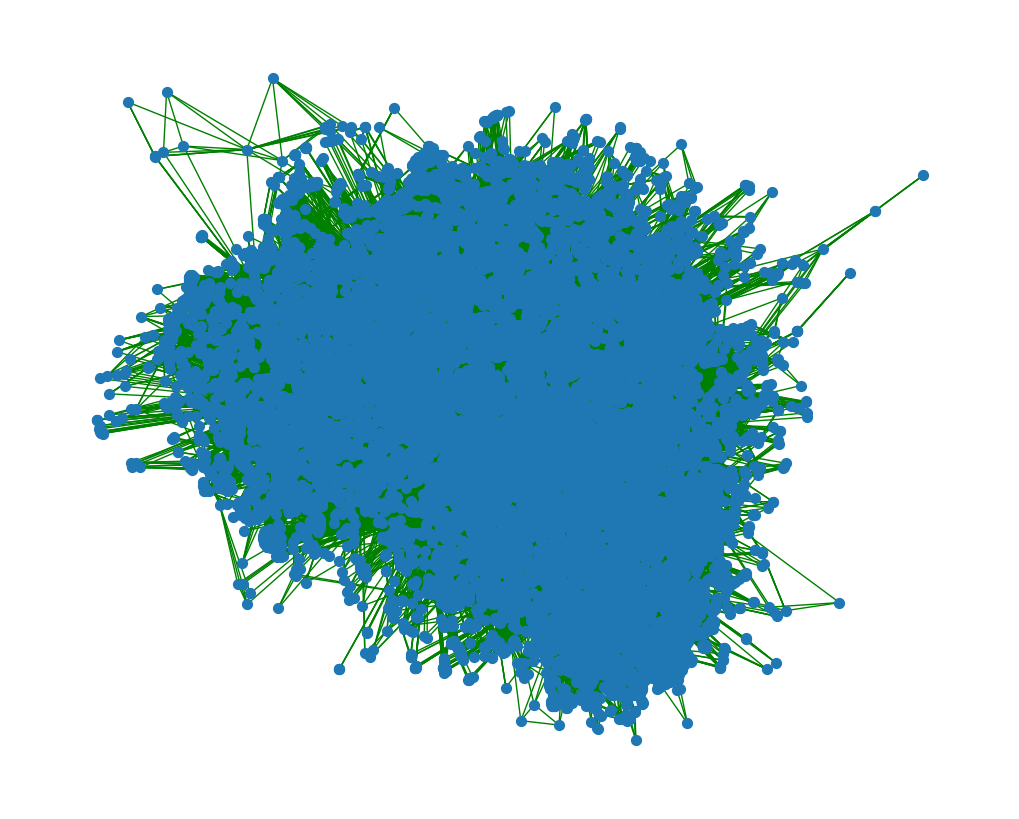

In [27]:
import matplotlib.pyplot as plt
edges_cursor = db.collection("edges").all()
edges = list(edges_cursor)

edges_df = pd.DataFrame(edges)
G = nx.from_pandas_edgelist(edges_df, source="_from", target="_to")

plt.figure(figsize=(10, 8))
nx.draw(G, with_labels=False, node_size=50, font_size=8, edge_color="green")
plt.show()